# Neural networks from scratch in Scala!




![null](https://lh4.googleusercontent.com/cu4A1znRGfRIUn0Bt_SREExhhQYhC2KKO5czYlqJaiN-SL3lrHgfmnHMBN7_9wnWVfSdY_uEvq5HvY3LT-n4X7st9PAB96qUMkPx-0XLhZzW5O0tOerQrqaqu0gPKkdgEIW8LIsqTew)<br>




The purpose of this notebook is to explain how to implement a simple neural network in Scala.


First some jargon.


In its simplest form, a neural net is a sequence of linear transformations (read matrix multiplications) glued together by **activation** functions. The task of the activation function is to introduce a non-linearity (such as setting the negative values to 0) between these transformations. The reason this works can be traced back to the Universal Approximation Theorem. The matrices are called **weights,** or **parameters.** The linear transformation together with the activation function is called a **layer**. Layers can be stacked together to form **modules**. The complete set of modules that compose the neural net is often called a **model**.


The neural net we'll be discussing is part of the supervised domain of machine learning. In supervised learning there is a learning, or **training** phase, and an **inference** phase.


In the training phase, a **dataloader** pushes **labeled** input in the form of a matrix (input) and a vector (expected outcome) to the model, where the multiplications and activations ensue.  The dataloader is responsible for transforming the semantic units of both input (a picture of a cat) and output (the label 'cat') into resp. a matrix and a vector of numbers. Data is usually loaded in multiples (eg. 64 images, together with their labels). These multiples are called **minibatches**.


A **loss function** compares the prediction of the network on each sample with the ground truth, ie. the label. It notifies the network of the errors it made, in the form of **gradients,** by a process called **backpropagation**. Subsequently an **optimizer** uses the gradients to nudge the weights into the direction of the correct outcome, by subtracting a fraction of the gradients from the weights. This fraction is called the **learning rate**.


This is repeated on every minibatch of the training data set. A complete processing on the training set in this way is called an **epoch**. The model is trained as many epochs as needed, ie. until the loss is sufficiently low, and the accuracy (or another metric) is satisfactory. The **validation set** is a special part of the training set, that was set aside beforehand. It is not used as input for the training, but only to assess how well or how bad we are doing on data the model has never seen before. The loss and accuracy metrics are also computed on the validation set, and these are an important source for adjusting the **hyperparameters** of the model, such as the learning rate.


In the inference phase, we use the trained model to make predictions on unseen, unlabeled data. In this phase there is no loss, no backprop, and no optimizer.<br>




## Using a numerical library


In order to build anything similar to the above design, we need a numerical library. Numsca is a library for the Scala programming language, inspired by NumPy, with


* support for matrices and tensors (multi-dimensional arrays)
* a collection of high-level mathematical functions to operate on these tensors
* broadcasting and fancy indexing, just like NumPy.


Numsca can be found at [https://github.com/botkop/numsca](https://github.com/botkop/numsca)




In [4]:
import botkop.{numsca => ns}
import ns.Tensor
import scala.language.implicitConversions

## Implementing Backpropagation


![null](https://lh4.googleusercontent.com/ISD7nDd6dwMkQaOpwxvq6gsNP5NCFWjwzTWl4HiPW_roXGPQV0S4Ryi8KcRx5KzA1GpG7VFFOwjSf6s2Gah_r-o8nUbJXRht91qzgujt8fNMcbKcpOW-eyAPD_OA9gxP0G9jFSuGcN0)<br>


The circuit diagram above shows a computation graph which allows to relate the value and gradient of the variables to the functions that produced them. In order to achieve this we will make 2 constructs that are defined in terms of each other:<br>


* 
  a Variable, which is a wrapper around a tensor. It also stores the originating Function of this Variable, if any. For example, the function of Variable x will be None if `x = Variable(ns.zeros(3, 3,))`, but will be `Mul` if `x = a * b`, where a and b are also Variables.
  
  
  
* 
  a Function, which has a `forward()` method that produces the standard result of a computation, and a `backward(g)` method where g is a tensor that represents the upstream gradient. The gradient is distributed among the composing Variables according to the rules of calculus, and passed on to the `backward(g)` methods of these Variables.
  
  
  


### Variables & Functions




In [6]:
/**
  * Wrapper around a tensor.
  * Keeps track of the computation graph by storing the originating function of this variable, if any.
  * The function will be None if the variable is the result of simple wrapping around a tensor.
  * If the variable is the result of a computation, then f will be set to the function behind this computation.
  * For example, f will be None if x = Variable(ns.zeros(3, 3,)), but f will be Mul if x = a * b,
  * where a and b are also Variables.
  *
  * @param data the tensor
  * @param f function that produced this variable, if any.
  */
case class Variable(data: Tensor, f: Option[Function] = None) {

  /* the local gradient */
  lazy val g: Tensor = ns.zerosLike(data)

  /**
    * Accumulates the incoming gradient in the local gradient.
    * Pushes the incoming gradient back through the network,
    * by means of the originating function, if any.
    * The gradient defaults to 1, as per the Calculus definition.
    * @param gradOutput the gradient that is being pushed back through the network
    */
  def backward(gradOutput: Tensor = ns.ones(data.shape)): Unit = {
    // gradients may have been broadcasted
    // squash the dimensions to fit the original shape
    val ug = unbroadcast(gradOutput)

    // Gradients add up at forks.
    // If the forward expression involves the variables x,y multiple times,
    // then when we perform backpropagation we must be careful to use += instead of =
    // to accumulate the gradient on these variables (otherwise we would overwrite it).
    // This follows the multivariable chain rule in Calculus,
    // which states that if a variable branches out to different parts of the circuit,
    // then the gradients that flow back to it will add.
    // http://cs231n.github.io/optimization-2/#staged
    g += ug

    // backprop thru the function that generated this variable, if any
    for (gf <- f) gf.backward(ug)
  }

  def +(other: Variable): Variable = Add(this, other).forward()
  def *(other: Variable): Variable = Mul(this, other).forward()
  def dot(other: Variable): Variable = Dot(this, other).forward()
  def t(): Variable = Transpose(this).forward()

  // chain operator, allows to attach variables to functions without using call syntax
  def ~>(f: Variable => Variable): Variable = f(this)
  def shape: List[Int] = data.shape.toList

  def unbroadcast(t: Tensor): Tensor =
    if (t.shape.sameElements(data.shape)) t
    else data.shape.zip(t.shape).zipWithIndex.foldLeft(t) {
        case (d: Tensor, ((oi, ni), i)) if oi == ni => 
            d
        case (d: Tensor, ((oi, ni), i)) if oi == 1 => 
            ns.sum(d, axis = i)
        case _ =>
            throw new Exception(
              s"unable to reduce broadcasted shape ${t.shape.toList} as ${data.shape.toList}")
    }
}

object Variable {
  // turn a sequence of numbers directly into a Variable
  def apply(ds: Double*): Variable = Variable(Tensor(ds:_*))
}

/**
 * The Function is the 2nd required component in keeping track of a computation graph.
 * It defines 2 methods: 
 *   forward(): produces the traditional result of a computation
 *   backward(g): takes a gradient and distributes it to the composing 
 *     Variables of the Function by calling their backward(g) method.
 */
trait Function {
  def forward(): Variable
  def backward(g: Tensor): Unit
}

case class Add(v1: Variable, v2: Variable) extends Function {
  def forward(): Variable = Variable(v1.data + v2.data, f = Some(this))
  /* The Add function distributes its gradient equally to all the inputs */
  def backward(g: Tensor): Unit = {
    v1.backward(g)
    v2.backward(g)
  }
}

case class Mul(v1: Variable, v2: Variable) extends Function {
  override def forward(): Variable = Variable(v1.data * v2.data, f = Some(this))
  /* The Mul function swaps the input activations, and multiplies them with the gradient */
  override def backward(g: Tensor): Unit = {
    val dv2 = v2.data * g
    val dv1 = v1.data * g
    v1.backward(dv2)
    v2.backward(dv1)
  }
}

case class Dot(v1: Variable, v2: Variable) extends Function {
  val w: Tensor = v1.data
  val x: Tensor = v2.data
  override def forward(): Variable = Variable(w dot x, f = Some(this))
  override def backward(g: Tensor): Unit = {
    val dw = g dot x.T
    val dx = w.T dot g
    v1.backward(dw)
    v2.backward(dx)
  }
}

case class Transpose(v: Variable) extends Function {
  override def forward(): Variable = Variable(v.data.transpose, Some(this))
  override def backward(gradOutput: Tensor): Unit =
    v.backward(gradOutput.transpose)
}

### Activation


Activation functions are element-wise functions that introduce a non-linearity in the network. RELU is the most commonly used activation. In the forward pass, it simply sets all negative values in a tensor equal to zero. In the backward pass, it routes the gradient to the input higher than 0.




In [8]:
case class Threshold(x: Variable, d: Double) extends Function {
  override def forward(): Variable = Variable(ns.maximum(x.data, d), Some(this))
  override def backward(gradOutput: Tensor): Unit = {
    x.backward(gradOutput * (x.data > d))
  }
}

def relu(x: Variable): Variable = Threshold(x, 0.0).forward()

### Module


A module is a wrapper around a set of Variables, here called parameters because they constitute the layers of a network.  When layers are stacked on top of each other, the encompassing module allows to dynamically pull up the parameters of its layers. This can be done by calling the `parameters` method. In the same way the gradients of all the layers can be pulled up through method `gradients`. The `zeroGrad` method allows to set all gradients of the parameters equal to 0. The Module behaves like a Function through the abstract methods `forward()` and `apply() `.




In [10]:
abstract class Module(localParameters: Seq[Variable] = Nil) {
  // by default, obtain submodules through introspection
  lazy val subModules: Seq[Module] =
    this.getClass.getDeclaredFields.flatMap { f =>
      f setAccessible true
      f.get(this) match {
        case module: Module => Some(module)
        case _ => None
      }
    }

  def parameters: Seq[Variable] = localParameters ++ subModules.flatMap(_.parameters)
  def gradients: Seq[Tensor] = parameters.map(_.g)
  def zeroGrad(): Unit = parameters.foreach(p => p.g := 0)

  def forward(x: Variable): Variable
  def apply(x: Variable): Variable = forward(x)
}

/* extend module to act as a Function/Variable */
implicit def moduleApply[T <: Module](m: T): (Variable) => Variable = m.forward

#### Linear Module


Applies a linear transformation (dot product) to its input.

![null](https://lh6.googleusercontent.com/Chnhg0qeogJWel8KkzP7r-TA8cBx7zOTnvNY2-J2oDzewUaiEtJqgcaT8Hb80JLHj-HL1YBu2Hs2XUDz6WQ4r_RjUDn6is_wQIA23OMAZuA4fR-ww6NV6cYKl8fbprxX7TW5NQ1uLao)<br>




In [12]:
case class Linear(weights: Variable, bias: Variable)
  extends Module(Seq(weights, bias)) {
  override def forward(x: Variable): Variable = {
    (x dot weights.t()) + bias
  }
}

object Linear {
  def apply(inFeatures: Int, outFeatures: Int): Linear = {
    /* He initialization */
    val w = ns.randn(outFeatures, inFeatures) * math.sqrt(2.0 / (inFeatures + outFeatures))
    val weights = Variable(w)
    val b = ns.zeros(1, outFeatures)
    val bias = Variable(b)
    Linear(weights, bias)
  }
}

### Optimizer

The task of an Optimizer is to nudge the parameters into the direction of the expected outcome of the model. At each step (epoch) it will be called to perform a function on the parameters, using their gradients, in order to achieve this. The Optimizer also provides a method to reset the gradients to 0, which should be called after each update of the parameters.




In [14]:
abstract class Optimizer(parameters: Seq[Variable]) {
  def step(epoch: Int)
  def zeroGrad(): Unit = parameters.foreach(p => p.g := 0)
}

#### Stochastic Gradient Descent

SGD is a type of Optimizer, that implements a simple yet very efficient approach to discriminative learning of a linear classifier. It subtracts a fraction of the gradient of a parameter from the parameter itself. This fraction is called the learning rate.




In [16]:
case class SGD(parameters: Seq[Variable], learningRate: Double) extends Optimizer(parameters) {
  override def step(epoch: Int): Unit =
    parameters.foreach { p =>
      p.data -= learningRate * p.g
    } 
}

### Softmax Loss function


The loss function quantifies our unhappiness with the score of the network. It measures the error between the predicted and the expected value. Intuitively, the loss will be high if we’re doing a poor job of classifying the training data, and it will be low if we’re doing well.


The goal of the network is to find parameters that minimize the loss over all samples.<br>


For a classification task, SoftMax Loss is often used used. It is a combination of a Softmax activation and a Cross Entropy Loss function. Usually they are combined into one function.


Softmax squashes the raw class scores into normalized positive values that sum to one. See also [http://neuralnetworksanddeeplearning.com/chap3.html#softmax](http://neuralnetworksanddeeplearning.com/chap3.html#softmax)




In [18]:
case class SoftmaxLoss(actual: Variable, target: Variable) extends Function {
  val x: Tensor = actual.data
  val y: Tensor = target.data.T

  val shiftedLogits: Tensor = x - ns.max(x, axis = 1)
  val z: Tensor = ns.sum(ns.exp(shiftedLogits), axis = 1)
  val logProbs: Tensor = shiftedLogits - ns.log(z)
  val n: Int = x.shape.head
  val loss: Double = -ns.sum(logProbs(ns.arange(n), y)) / n

  override def forward(): Variable = Variable(Tensor(loss), Some(this))

  override def backward(gradOutput: Tensor /* not used */ ): Unit = {
    val dx = ns.exp(logProbs)
    dx(ns.arange(n), y) -= 1
    dx /= n

    actual.backward(dx)
  }
}

type LossFunction = (Variable, Variable) => Variable

val softmaxLoss: LossFunction = (yHat: Variable, y: Variable) => SoftmaxLoss(yHat, y).forward

### Data Loader



In [20]:
trait DataLoader extends Iterable[(Variable, Variable)] {
  def numSamples: Int
  def numBatches: Int
  def mode: String
  def iterator: Iterator[(Variable, Variable)]
}

#### Fashion MNIST data loader


This dataloader reads the Fashion MNIST dataset from Zalando: [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist). The dataset is provided here in gzipped CSV format, where each line represents an image and its label. There are 10 classes: t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag and ankle boot. It is a dataset with 60K training images and 10K validation images. 

![null](https://lh5.googleusercontent.com/7Xqv2Jv43OuCW7i6mxnSxjuwSjw1F44zYTdCvNT-NsdiknV_w1b_iGPG-zSqGM63pADAOMOiFXVfqHcemAj0_lZ0hvVA5VJHjJODtuOyhI-urL698nP3o61JeNMJa4n_eAri4VxDJYg)<br>

Each image consists of 28x28 grayscale pixels. The values of the pixels in the files are all integers between 0 and 255.![null](https://lh6.googleusercontent.com/WEAhMWdX4jvAt_YmzbGYQBI1Ps-r1bR8MbSiNeamrcaSvfpLw97JXcFkIl8VWQx9toWtE6_xHaveJEgABpPjXF4q4-RNxqRmOJQ9sUypAlAsX_CcAYhE8Je6sn_97HRwK1hcOhYxbJQ)


The dataloader turns the values into floats between 0 and 1 by dividing the values for the pixels by 255.0. It also applies zero centering: subtract the mean across every individual feature in the data. The geometric interpretation for this is to center the data around the origin along every dimension.![null](https://lh6.googleusercontent.com/FIMtQpv15k7jzZT7xqN6DKZ9g2D-TDQshw1vFSlChm6JsybSSqffqjTKa1AoySxixu6sos9IPI2IFgyu6YDntSwzPyVl0KG9yZ-pc-TXtYy6UHkWTFuwDtFSmVvZ-dZGDh2A5tSvkVk)


Caveat: when zero-centering test data, the mean of the training data must be subtracted from the test data.




In [22]:
import scala.io.Source
import scala.language.postfixOps
import scala.util.Random
import java.util.zip.GZIPInputStream
import java.io._

val baseFolder ="dl-from-scratch-polynb/data/fashionmnist"

class FashionMnistDataLoader(val mode: String,
                             miniBatchSize: Int,
                             take: Option[Int] = None,
                             seed: Long = 231)
    extends DataLoader {

  Random.setSeed(seed)

  val file: String = mode match {
    case "train" => s"$baseFolder/fashion-mnist_train.csv.gz"
    case "valid" => s"$baseFolder/fashion-mnist_test.csv.gz"
  }

  def gis(f: String) = Source.fromInputStream(
    new GZIPInputStream(new BufferedInputStream(new FileInputStream(f))))

  val lines: List[String] = {
    val src = gis(file)
    val lines = src.getLines().toList
    src.close()
    Random.shuffle(lines.tail) // skip header
  }

  val numFeatures = 784
  val numEntries: Int = lines.length

  val numSamples: Int = take match {
    case Some(n) => math.min(n, numEntries)
    case None    => numEntries
  }

  val numBatches: Int =
    (numSamples / miniBatchSize) +
      (if (numSamples % miniBatchSize == 0) 0 else 1)

  val data: Seq[(Variable, Variable)] = lines
    .take(take.getOrElse(numSamples))
    .sliding(miniBatchSize, miniBatchSize)
    .map { lines =>
      val batchSize = lines.length

      val xs = Array.fill[Float](numFeatures * batchSize)(elem = 0)
      val ys = Array.fill[Float](batchSize)(elem = 0)

      lines.zipWithIndex.foreach {
        case (line, lnr) =>
          val tokens = line.split(",")
          ys(lnr) = tokens.head.toFloat
          tokens.tail.zipWithIndex.foreach {
            case (sx, i) =>
              xs(lnr * numFeatures + i) = sx.toFloat / 255.0f
          }
      }

      val x = Variable(Tensor(xs).reshape(batchSize, numFeatures))
      val y = Variable(Tensor(ys).reshape(batchSize, 1))
      (x, y)
    }
    .toSeq

  lazy val meanImage: Tensor = {
    val m = ns.zeros(1, numFeatures)
    data.foreach {
      case (x, _) =>
        m += ns.sum(x.data, axis = 0)
    }
    m /= numSamples
    m
  }

  if (mode == "train") zeroCenter(meanImage)

  def zeroCenter(meanImage: Tensor): Unit = {
    val bcm = broadcastTo(meanImage, miniBatchSize, numFeatures)

    data.foreach {
      case (x, _) =>
        if (x.data.shape.head == miniBatchSize)
          x.data -= bcm
        else
          x.data -= meanImage
    }
  }

  def iterator: Iterator[(Variable, Variable)] =
    Random.shuffle(data.toIterator)

  def broadcastTo(t: Tensor, shape: Int*): Tensor =
    new Tensor(t.array.broadcast(shape: _*))

}

### Evaluator



In [24]:
trait Evaluator {
  def evaluate(epoch: Int, startTime: Long, endTime: Long, net: Module, loss: LossFunction): Unit
}

import scala.collection.mutable.ArrayBuffer

case class Metric(loss: Double, accuracy: Double)

case class MyEvaluator(trainDataLoader: DataLoader,
                       validDataLoader: DataLoader,
                       loss: LossFunction) extends Evaluator{

  val trnMetrics = ArrayBuffer[Metric]()
  val valMetrics = ArrayBuffer[Metric]()

  def evaluate(epoch: Int, t0: Long, t1: Long, net: Module, loss: LossFunction): Unit = {
    val dur = (t1 - t0) / 1000000
    val (ltrn, atrn) = evaluate(trainDataLoader, net, trnMetrics)
    val (lval, aval) = evaluate(validDataLoader, net, valMetrics)
    println(
        f"epoch: $epoch%2d duration: $dur%4dms loss: $lval%1.4f / $ltrn%1.4f\taccuracy: $aval%1.4f / $atrn%1.4f")
  }

  def evaluate(dl: DataLoader,
               net: Module,
               metrics: ArrayBuffer[Metric]): (Double, Double) = {
    val (l, a) =
      dl.foldLeft(0.0, 0.0) {
        case ((lossAcc, accuracyAcc), (x, y)) =>
          val output = net(x)
          val guessed = ns.argmax(output.data, axis = 1)
          val accuracy = ns.sum(guessed == y.data) / x.shape.head
          val cost = loss(output, y).data.squeeze()
          metrics += Metric(cost, accuracy)
          (lossAcc + cost, accuracyAcc + accuracy)
      }
    (l / dl.numBatches, a / dl.numBatches)
  }
}

### Learner


Convenience class around the learning process. You provide it with the training datasets, the model layout to train, an optimizer, a loss function, and an evaluator.


The class provides a fit method, that will train the model for the required number of epochs. The model is evaluated after each epoch.




In [26]:
case class Learner(trainingDataLoader: DataLoader,
                   net: Module,
                   optimizer: Optimizer,
                   loss: LossFunction,
                   evaluator: Evaluator) {

  def fit(numEpochs: Int): Unit = {
    (0 until numEpochs) foreach { epoch =>
      val t0 = System.nanoTime()
      trainingDataLoader.foreach { // for each mini batch
        case (x, y) =>
          optimizer.zeroGrad()
          val yh = net(x)
          val l = loss(yh, y)
          l.backward()
          optimizer.step(epoch) // update parameters using their gradient
      }
      val t1 = System.nanoTime()
      evaluator.evaluate(epoch, t0, t1, net, loss)
    }
  }
}

### Train a network


Create the data loaders for the training and validation data sets. The instantiation of the dataloaders may take some time.




In [28]:
val batchSize = 256
val trainDl = new FashionMnistDataLoader("train", batchSize)
val validDl = new FashionMnistDataLoader("valid", batchSize)

In the next cell we define the layout of our network: 2 linear transformations with a RELU activation in between. 




In [30]:
val nn: Module = new Module() {
    val fc1 = Linear(784, 100)
    val fc2 = Linear(100, 10)
    override def forward(x: Variable): Variable = 
        x ~> fc1 ~> relu ~> fc2
}

Next, we define the optimizer for the given learning rate, and the number of epochs we want to train the model. And start the training.


You should not expect state-of-the-art results with this simple network. It just proves that the model can learn.




In [32]:
val numEpochs = 10
val learningRate = .1

val sgd = SGD(nn.parameters, learningRate)
val eval = MyEvaluator(trainDl, validDl, softmaxLoss)

In [33]:
Learner(trainDl, nn, sgd, softmaxLoss, eval).fit(numEpochs)

epoch:  0 duration: 4489ms loss: 1.1027 / 0.6857	accuracy: 0.6239 / 0.7707
epoch:  1 duration: 4074ms loss: 0.9651 / 0.5685	accuracy: 0.6580 / 0.8021
epoch:  2 duration: 4009ms loss: 0.9035 / 0.5170	accuracy: 0.6728 / 0.8179
epoch:  3 duration: 3903ms loss: 0.8588 / 0.4870	accuracy: 0.6893 / 0.8280
epoch:  4 duration: 3911ms loss: 0.8219 / 0.4665	accuracy: 0.7039 / 0.8338
epoch:  5 duration: 3903ms loss: 0.8118 / 0.4504	accuracy: 0.7076 / 0.8390
epoch:  6 duration: 3891ms loss: 0.8205 / 0.4380	accuracy: 0.6936 / 0.8439
epoch:  7 duration: 3888ms loss: 0.7858 / 0.4269	accuracy: 0.7153 / 0.8483
epoch:  8 duration: 3995ms loss: 0.7931 / 0.4176	accuracy: 0.7109 / 0.8516
epoch:  9 duration: 3992ms loss: 0.7838 / 0.4100	accuracy: 0.7157 / 0.8545


In [37]:
case class IndexedMetric(i: Int, loss: Double, accuracy: Double)

In [34]:
eval.trnMetrics.zipWithIndex.map { case (m, i) => 
  IndexedMetric(i, m.loss, m.accuracy)
}

ArrayBuffer(IndexedMetric(0,0.6547170281410217,0.80078125), IndexedMetric(1,0.6945062875747681,0.77734375), IndexedMetric(2,0.6640556454658508,0.7890625), IndexedMetric(3,0.7174513936042786,0.74609375), IndexedMetric(4,0.7206760048866272,0.765625), Index


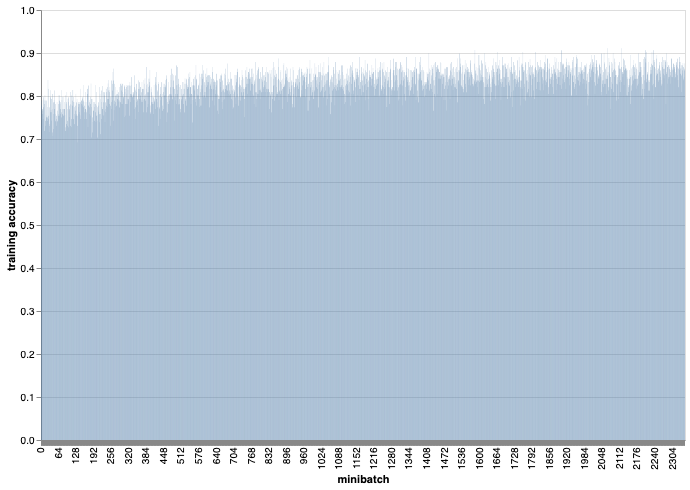

In [42]:
({
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {
    "name": "Out",
    "values": Out.aggregate(["i"], [{"accuracy":"mean"}])
  },
  "mark": "bar",
  "encoding": {
    "x": {
      "field": "i",
      "type": "ordinal",
      "axis": {
        "title": "minibatch"
      }
    },
    "y": {
      "field": "mean(accuracy)",
      "type": "quantitative",
      "axis": {
        "title": "training accuracy"
      }
    }
  },
  "width": 680,
  "height": 480,
  "autosize": "fit"
})


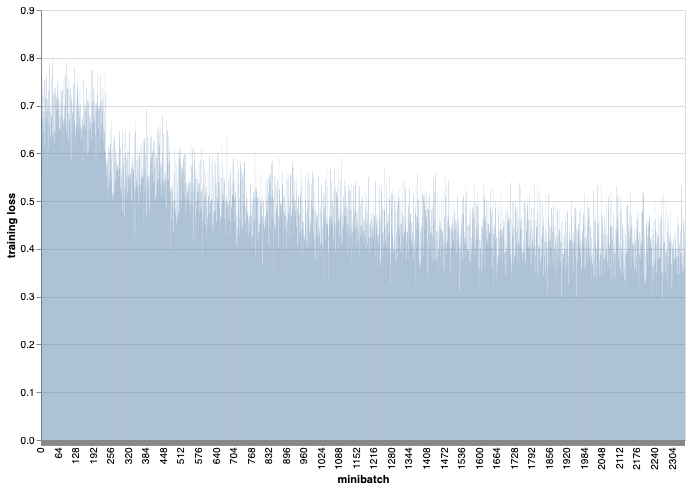

In [39]:
({
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {
    "name": "Out",
    "values": Out.aggregate(["i"], [{"loss":"mean"}])
  },
  "mark": "bar",
  "encoding": {
    "x": {
      "field": "i",
      "type": "ordinal",
      "axis": {
        "title": "minibatch"
      }
    },
    "y": {
      "field": "mean(loss)",
      "type": "quantitative",
      "axis": {
        "title": "training loss"
      }
    }
  },
  "width": 680,
  "height": 480,
  "autosize": "fit"
})

In [35]:
eval.valMetrics.zipWithIndex.map { case (m, i) => 
  IndexedMetric(i, m.loss, m.accuracy)
}

ArrayBuffer(IndexedMetric(0,1.0174918174743652,0.66015625), IndexedMetric(1,1.1357812881469727,0.6015625), IndexedMetric(2,1.1574293375015259,0.5859375), IndexedMetric(3,1.0646835565567017,0.609375), IndexedMetric(4,1.0267614126205444,0.6484375), Indexed


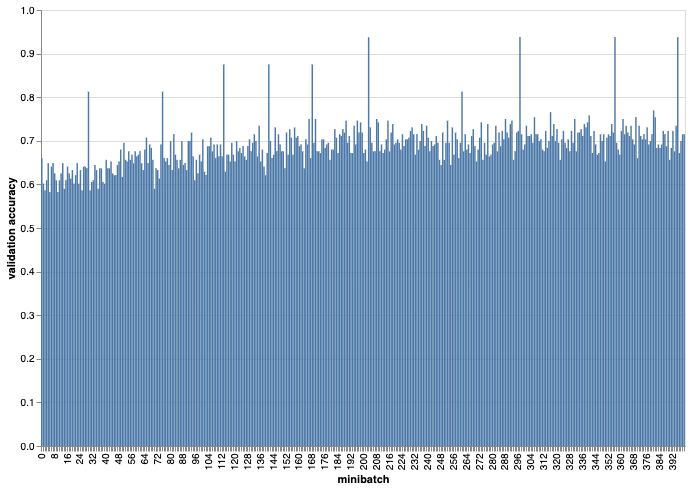

In [41]:
({
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {
    "name": "Out",
    "values": Out.aggregate(["i"], [{"accuracy":"mean"}])
  },
  "mark": "bar",
  "encoding": {
    "x": {
      "field": "i",
      "type": "ordinal",
      "axis": {
        "title": "minibatch"
      }
    },
    "y": {
      "field": "mean(accuracy)",
      "type": "quantitative",
      "axis": {
        "title": "validation accuracy"
      }
    }
  },
  "width": 680,
  "height": 480,
  "autosize": "fit"
})


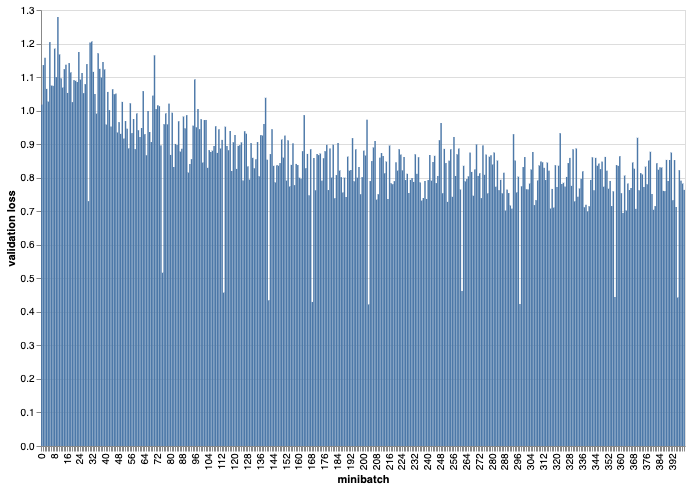

In [40]:
({
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {
    "name": "Out",
    "values": Out.aggregate(["i"], [{"loss":"mean"}])
  },
  "mark": "bar",
  "encoding": {
    "x": {
      "field": "i",
      "type": "ordinal",
      "axis": {
        "title": "minibatch"
      }
    },
    "y": {
      "field": "mean(loss)",
      "type": "quantitative",
      "axis": {
        "title": "validation loss"
      }
    }
  },
  "width": 680,
  "height": 480,
  "autosize": "fit"
})